In [1]:
# https://data.mendeley.com/datasets/kfth5g2xk3/2

# The dataset from this link contains 5 sub datasets, We are using the main one that contains the data of potholes, as well as cracks.
# The dataset hierarchy is as follows:

# pothole-mix
#      |
#      |- testing
#            |- ...
#      |- validation
#            |- ...
#      |- training
#            |- cnr-road-dataset
#            |- crack500
#            |- * cracks-and-potholes-in-road *
#                           |- images
#                           |- masks
#            |- edmcrack600
#            |- gaps384
#            |- pothole600

# Images are all RGB with 1024 x 640 dimensions, in JPG format
# Each mask is also an RGB corresponding to each image (Background -> Black, Cracks -> Green, Potholes -> Red), in PNG format

In [2]:
root = "pothole-mix"
dataset_to_use = "cracks-and-potholes-in-road"

In [3]:
import os
import glob

import torch
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torchmetrics import JaccardIndex

from torch import nn
from torchvision.ops import Conv2dNormActivation

import numpy as np
import matplotlib.pyplot as plt

In [4]:
class PotholeDataset(torch.utils.data.Dataset):
    def __init__(self, root, split="train", transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms

        # Check if "split" is valid
        if not split in ("train", "test", "valid"):
            raise Exception(f"Unknown split: <{split}>, Choose from ('train', 'test', 'valid')")
        else:
            # If so, map it to actual naming in the dataset
            split_map = {"train": "training", "valid": "validation", "test": "testing"}
            self.split = split_map[split]

        # Build the path for dataset "pothole-mix/training/cracks-and-potholes-in-road"
        self.dataset_path = os.path.join(self.root, self.split, dataset_to_use)
        # Gather all the images from images directory
        self.image_paths = glob.glob(os.path.join(self.dataset_path, "images", "*.jpg"))

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path).rstrip("jpg") + "png"
        mask_path = os.path.join(self.dataset_path, "masks", filename)

        image = read_image(image_path) / 255.0 # Shape: [C, H, W] = [3, 620, 1024]
        mask = read_image(mask_path) # Shape: [C, H, W] = [3, 620, 1024]

        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)

        # Access the potholes (Red -> (255, 0, 0)) and set them to "1"
        potholes = mask[0, :, :]
        potholes[potholes == 255] = 1

        # Access the cracks (Green -> (0, 255, 0)) and set them to "2"
        cracks = mask[1, :, :]
        cracks[cracks == 255] = 2
        
        encoded_mask = potholes + cracks

        return (image, encoded_mask)
    
    def decode_mask(self, mask):
        red = torch.where(mask == 1, 255, 0)
        green = torch.where(mask == 2, 255, 0)
        blue = torch.zeros_like(red)
        decoded_mask = torch.stack([red, green, blue])
        return decoded_mask


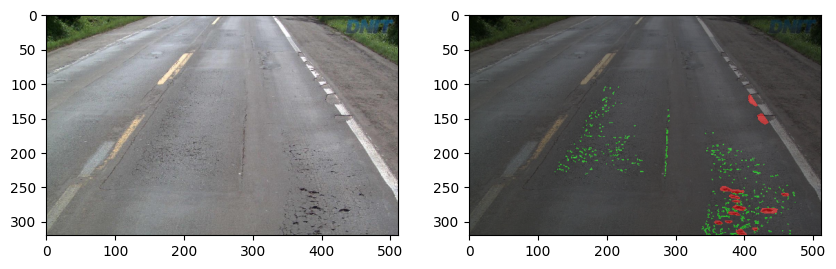

In [5]:
data_transforms = transforms.Compose([
    transforms.Resize([320, 512], interpolation=torchvision.transforms.InterpolationMode.NEAREST),
])

dataset_train = PotholeDataset(root=root, split="train", transforms=data_transforms)
img, mask = dataset_train[5]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(122)
plt.imshow(img.permute(1, 2, 0))
plt.imshow(dataset_train.decode_mask(mask).permute(1, 2, 0), alpha=0.5)

In [6]:
batch_size = 4
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_valid = PotholeDataset(root=root, split="valid", transforms=data_transforms)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size)

In [7]:
images, masks = next(iter(loader_train))

In [8]:
images.dtype

torch.float32

Text(0.5, 1.0, 'Sample images overlayed with masks')

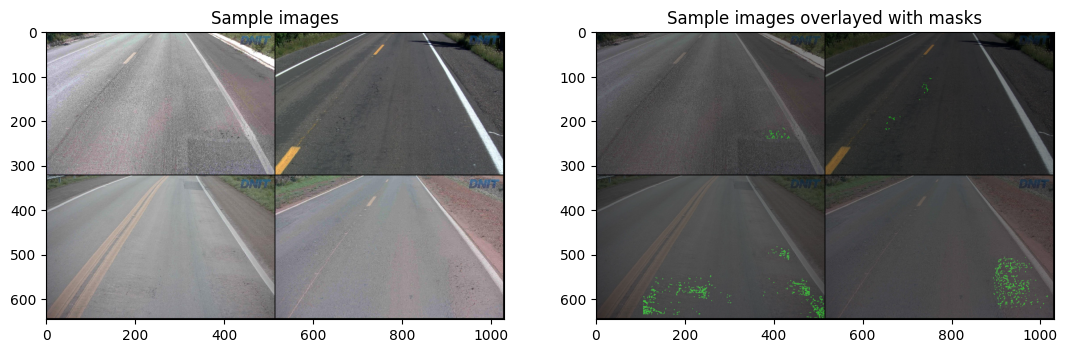

In [9]:
plt.figure(figsize=(13, 20))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(images, nrow=2).permute(1, 2, 0))
plt.title("Sample images")
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(images, nrow=2).permute(1, 2, 0))
plt.imshow(torchvision.utils.make_grid(torch.stack([dataset_train.decode_mask(i) for i in list(masks)]), nrow=2).permute(1, 2, 0), alpha=0.5)
plt.title("Sample images overlayed with masks")

# Data Modelling

## UNet Architecture
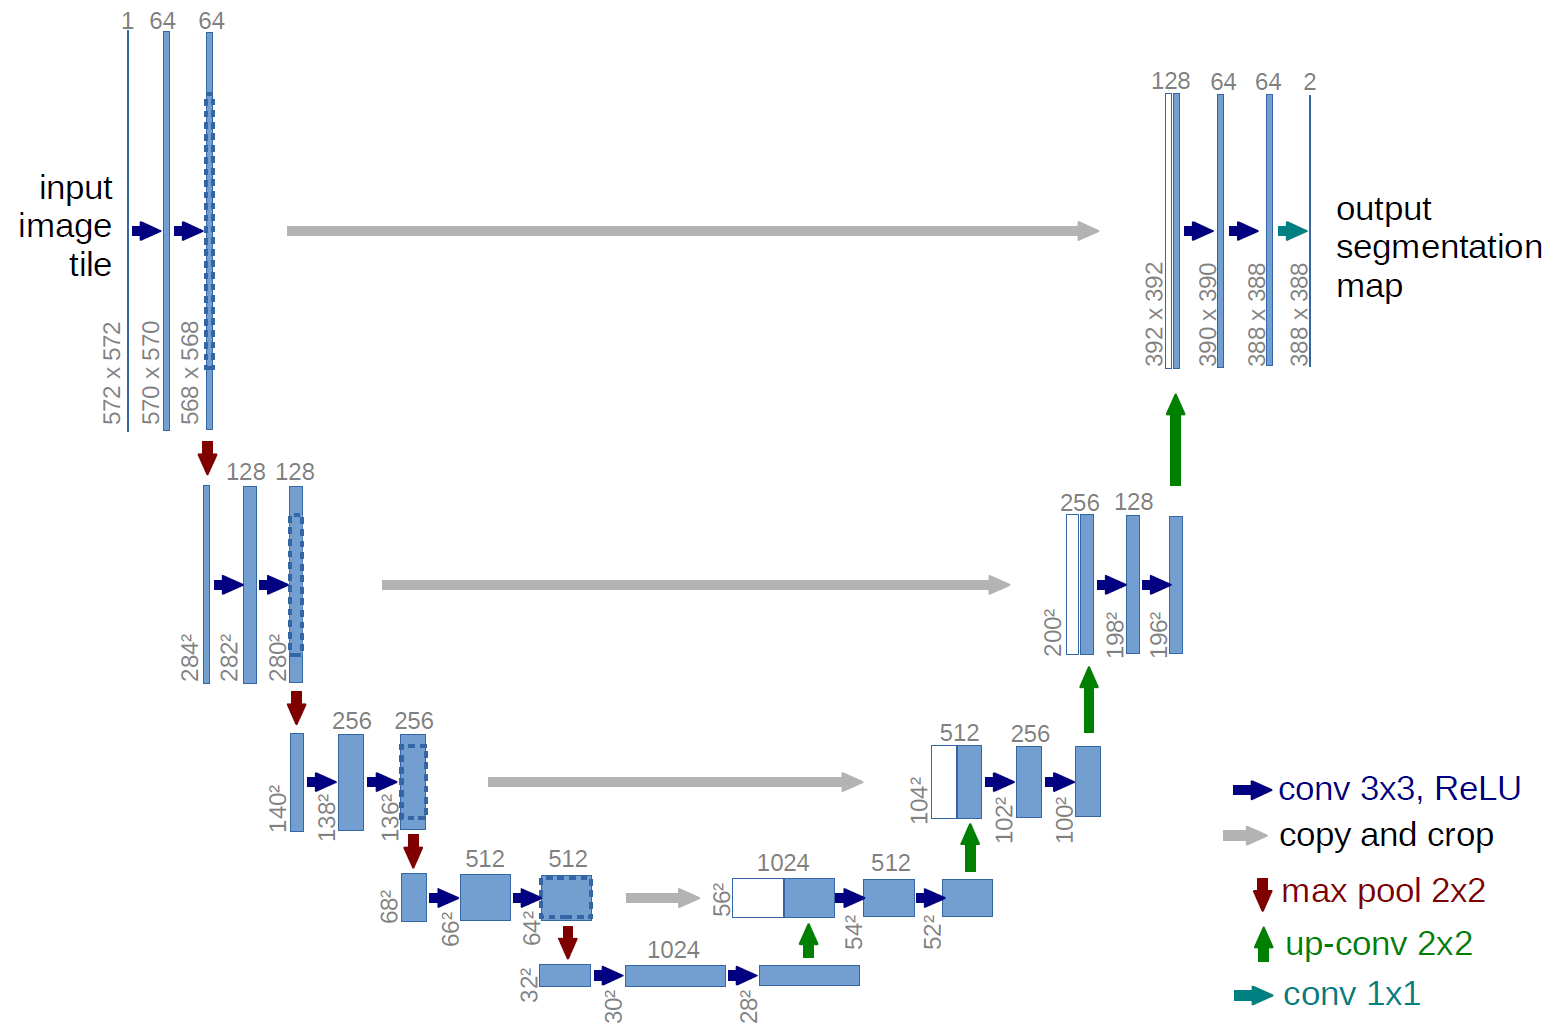

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, layers=2, **kwargs):
        super().__init__()
        self.layers = layers
        self.conv1 = Conv2dNormActivation(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            norm_layer=nn.BatchNorm2d,
            activation_layer=nn.LeakyReLU,
            **kwargs
            )
        self.conv2 = Conv2dNormActivation(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            norm_layer=nn.BatchNorm2d,
            activation_layer=nn.LeakyReLU,
            **kwargs
            )
        self.conv3 = Conv2dNormActivation(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            norm_layer=nn.BatchNorm2d,
            activation_layer=nn.LeakyReLU,
            **kwargs
            )
    
    def forward(self, x):
        x = self.conv2(self.conv1(x))
        if self.layers == 2:
            return x
        return self.conv3(x)


class UNet(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()

        # C x  H  x  W
        # 3 x 320 x 512 
        self.enc_conv1 = ConvBlock(in_channels=3, out_channels=64)
        # 64 x 320 x 512
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64 x 160 x 256

        self.enc_conv2 = ConvBlock(in_channels=64, out_channels=128)
        # 128 x 160 x 256
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 128 x 80 x 128

        self.enc_conv3 = ConvBlock(in_channels=128, out_channels=256)
        # 256 x 80 x 128
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 256 x 40 x 128

        self.enc_conv4 = ConvBlock(in_channels=256, out_channels=512)
        # 512 x 40 x 128
        self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 512 x 20 x 64

        self.enc_conv5 = ConvBlock(in_channels=512, out_channels=1024)
        # 1024 x 20 x 64      

        self.upconv5 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        # 512 x 40 x 128
        # Concatenation from enc_conv4 produces # 1024 x 40 x 128
        self.dec_conv5 = ConvBlock(in_channels=1024, out_channels=512)
        # 512 x 40 x 128

        self.upconv4 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        # 256 x 80 x 256
        # Concatenation from enc_conv3 produces # 512 x 80 x 256
        self.dec_conv4 = ConvBlock(in_channels=512, out_channels=256)
        # 256 x 80 x 256

        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        # 128 x 160 x 512
        # Concatenation from enc_conv2 produces # 256 x 160 x 512
        self.dec_conv3 = ConvBlock(in_channels=256, out_channels=128)
        # 128 x 160 x 512

        self.upconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        # 64 x 320 x 512
        # Concatenation from enc_conv1 produces # 128 x 320 x 512
        self.dec_conv2 = ConvBlock(in_channels=128, out_channels=64)
        # 64 x 320 x 512

        self.output_layer = ConvBlock(in_channels=64, out_channels=n_classes, kernel_size=1)
        # 3 x 320 x 512
    
    def forward(self, x):
        x_ec1 = self.enc_conv1(x)
        x = self.mp1(x_ec1)

        x_ec2 = self.enc_conv2(x)
        x = self.mp2(x_ec2)

        x_ec3 = self.enc_conv3(x)
        x = self.mp3(x_ec3)

        x_ec4 = self.enc_conv4(x)
        x = self.mp4(x_ec4)

        x = self.enc_conv5(x)

        x = self.upconv5(x)
        x = self.dec_conv5(torch.cat([x_ec4, x], dim=1))

        x = self.upconv4(x)
        x = self.dec_conv4(torch.cat([x_ec3, x], dim=1))

        x = self.upconv3(x)
        x = self.dec_conv3(torch.cat([x_ec2, x], dim=1))

        x = self.upconv2(x)
        x = self.dec_conv2(torch.cat([x_ec1, x], dim=1))

        x = self.output_layer(x)
        return x

### Components

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
unet_model = UNet()
unet_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3)
compute_iou = JaccardIndex(num_classes=3, task="multiclass").to(device)

### Verification run

In [13]:
images = images.to(device)
outputs = unet_model(images)
outputs.shape

torch.Size([4, 3, 320, 512])

In [14]:
masks = masks.to(device)
loss = loss_fn(outputs, masks.long())
loss

tensor(1.1902, grad_fn=<NllLoss2DBackward0>)

In [15]:
iou_ = compute_iou(outputs.argmax(dim=1), masks)
iou_

tensor(0.0714)

In [16]:
total_loss = loss + iou_
total_loss.backward()

### Main Training - UNet

In [17]:
def train(loader_train, loader_valid, model, loss_fn, optimizer, n_epochs=10):
    metrics = {"train": {"ce_loss": [], "iou": [], "total": []},
               "valid": {"ce_loss": [], "iou": [], "total": []}}
    for epoch in range(1, n_epochs+1):
        # TRAINING
        model.train()
        epoch_ce_loss = []
        epoch_iou = []
        epoch_total = []
        for batch_num, (images, masks) in enumerate(loader_train):
            # Transfer images and masks to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Feed forward, and perform predictions
            outputs = model(images)
            # Compute Cross Entropy Loss and store it
            ce_loss = loss_fn(outputs, masks.long())
            epoch_ce_loss.append(ce_loss.item())
            # Compute IoU Score and store it
            iou_score = compute_iou(outputs.argmax(dim=1), masks)
            epoch_iou.append(iou_score.item())
            # Compute Total Loss and store it
            total_loss = ce_loss + (1 - iou_score)
            epoch_total.append(total_loss.item())
            
            # Back propagate gradients
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # For every 10 batches, print status
            if batch_num % 10 == 0:
                print(f"[Epoch {epoch}/{n_epochs}] [{batch_num}/{len(loader_train)}] CE Loss: {loss.item()} | IoU: {iou_score.item()} | Total Loss: {total_loss.item()}")
        
        metrics["train"]["ce_loss"].append(np.mean(epoch_ce_loss))
        metrics["train"]["iou"].append(np.mean(epoch_iou))
        metrics["train"]["total"].append(np.mean(epoch_total))
        
        # VALIDATION
        model.eval()
        epoch_ce_loss = []
        epoch_iou = []
        epoch_total = []
        for images, masks in loader_valid:
            # Transfer images and masks to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Feed forward, and perform predictions
            outputs = model(images)
            # Compute Cross Entropy Loss and store it
            ce_loss = loss_fn(outputs, masks.long())
            epoch_ce_loss.append(ce_loss.item())
            # Compute IoU Score and store it
            iou_score = compute_iou(outputs.argmax(dim=1), masks)
            epoch_iou.append(iou_score.item())
            # Compute Total Loss and store it
            total_loss = ce_loss + (1 - iou_score)
            epoch_total.append(total_loss.item())


        print(f"[Epoch {epoch}/{n_epochs}] [VALIDATION] CE Loss: {np.mean(epoch_ce_loss)} | IoU: {np.mean(epoch_iou)} | Total Loss: {np.mean(epoch_total)}")
        print()
        
        metrics["valid"]["ce_loss"].append(np.mean(epoch_ce_loss))
        metrics["valid"]["iou"].append(np.mean(epoch_iou))
        metrics["valid"]["total"].append(np.mean(epoch_total))

    return metrics

In [19]:
unet_scores = train(
        loader_train=loader_train,
        loader_valid=loader_valid,
        model=unet_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        n_epochs=1
        )

[Epoch 1/1] [0/500] CE Loss: 1.1902258396148682 | IoU: 0.48840218782424927 | Total Loss: 0.5336854457855225


KeyboardInterrupt: 

In [18]:
unet_model_save_name = "model_unet_state_dict.pth"
unet_scores = {}
if os.path.exists(unet_model_save_name):
    unet_model.load_state_dict(torch.load(unet_model_save_name, map_location=device))
    unet_scores = torch.load("unet_scores.pth", map_location=device)
    print("[UNet] Loaded saved model and metrics")
else:
    unet_scores = train(
        loader_train=loader_train,
        loader_valid=loader_valid,
        model=unet_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        n_epochs=1
        )
    torch.save(unet_model.state_dict(), "model_unet_state_dict.pth")
    torch.save(unet_scores, "unet_scores.pth")

[UNet] Loaded saved model and metrics


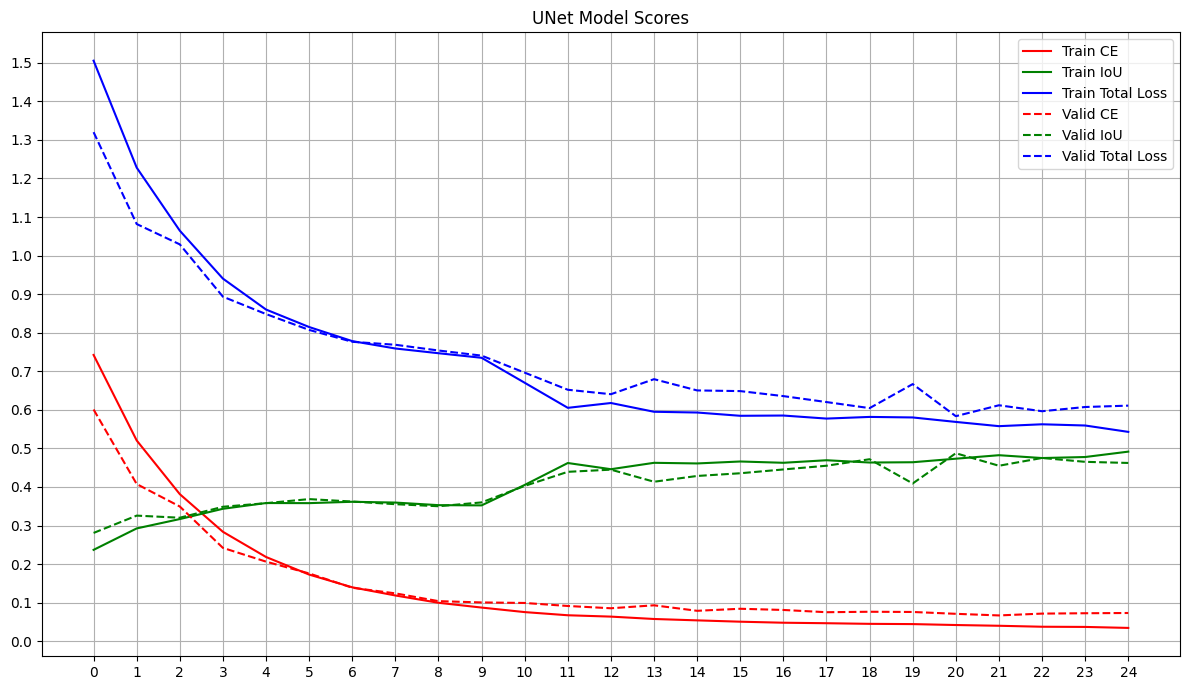

In [90]:
unet_train, unet_valid = unet_scores["train"], unet_scores["valid"]
plt.figure(figsize=(12, 7))
plt.grid("on")
plt.plot(unet_train["ce_loss"], color="red", label="Train CE")
plt.plot(unet_train["iou"], color="green", label="Train IoU")
plt.plot(unet_train["total"], color="blue", label="Train Total Loss")

plt.plot(unet_valid["ce_loss"], color="red", linestyle="dashed", label="Valid CE")
plt.plot(unet_valid["iou"], color="green", linestyle="dashed", label="Valid IoU")
plt.plot(unet_valid["total"], color="blue", linestyle="dashed", label="Valid Total Loss")

plt.xticks(range(0, 25), range(0, 25))
plt.yticks(np.arange(0, 1.6, 0.1), np.around(np.arange(0, 1.6, 0.1), 2))
plt.title("UNet Model Scores")
plt.legend()
plt.tight_layout()

In [129]:
iterable_train_loader = iter(loader_train)
valid_images, valid_masks = next(iterable_train_loader)
valid_images, valid_masks = next(iterable_train_loader)
valid_preds_unet = unet_model(valid_images)

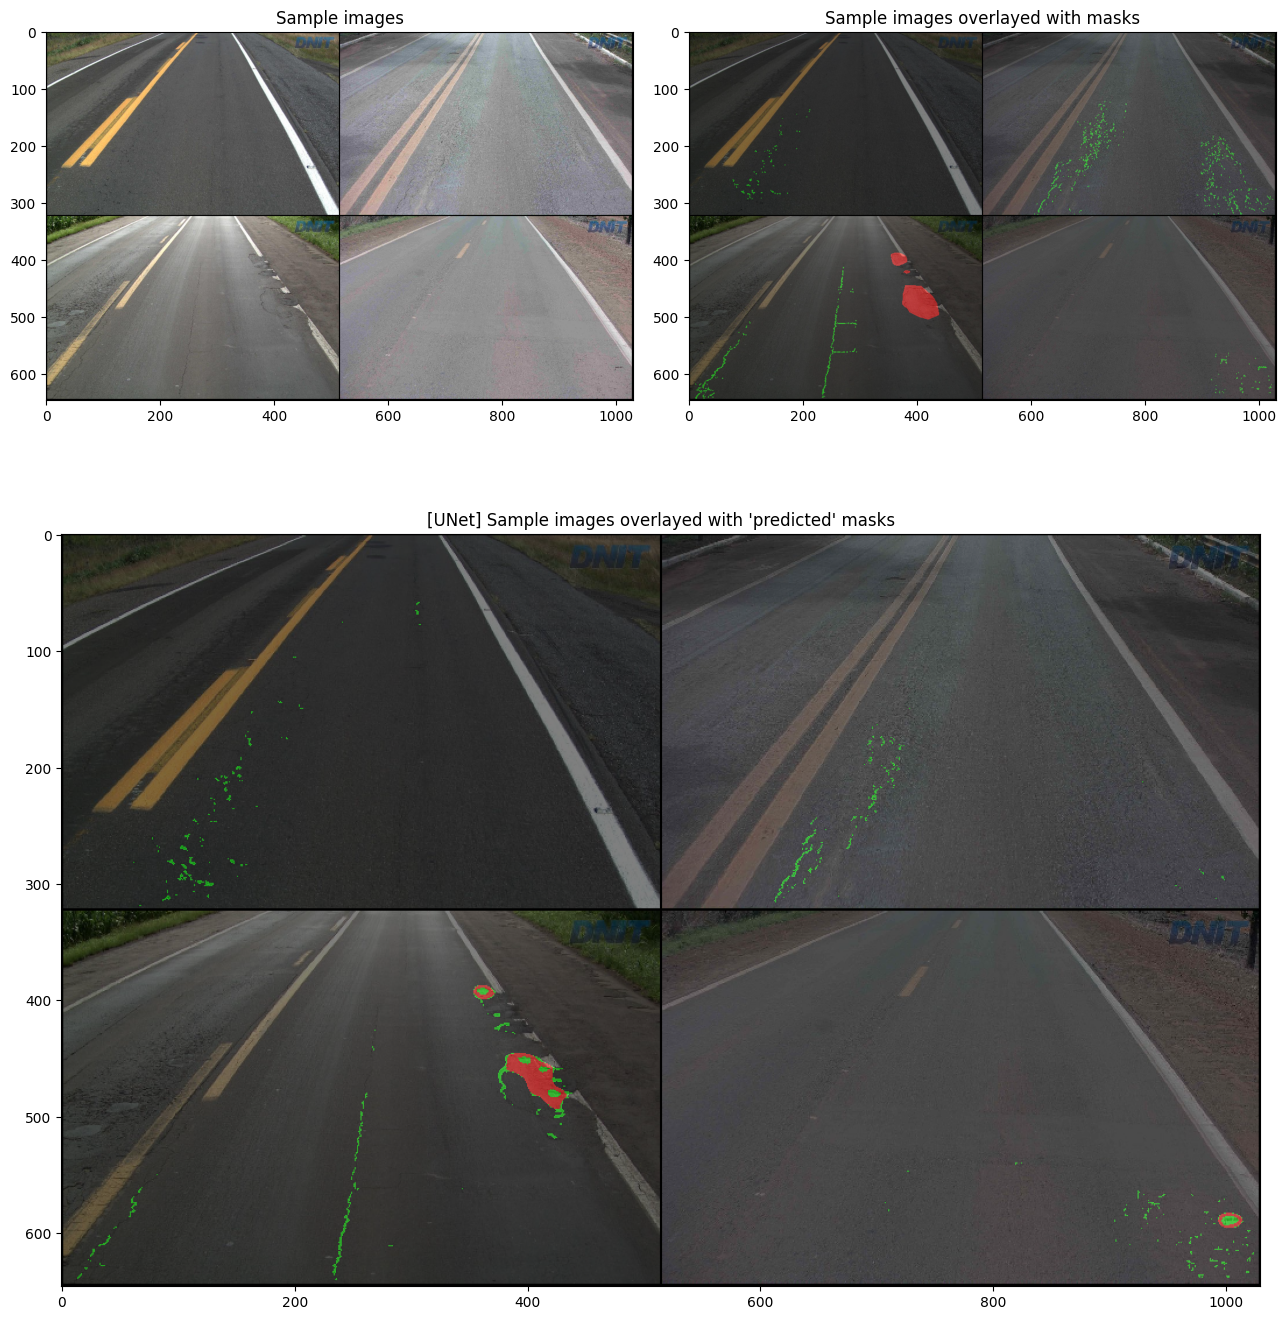

In [130]:
plt.figure(figsize=(13, 15))
plt.subplot(2, 2, 1)
plt.imshow(torchvision.utils.make_grid(valid_images, nrow=2).permute(1, 2, 0))
plt.title("Sample images")
plt.subplot(2, 2, 2)
plt.imshow(torchvision.utils.make_grid(valid_images, nrow=2).permute(1, 2, 0))
plt.imshow(torchvision.utils.make_grid(torch.stack([dataset_train.decode_mask(i) for i in list(valid_masks)]), nrow=2).permute(1, 2, 0), alpha=0.5)
plt.title("Sample images overlayed with masks")
plt.subplot(2, 1, 2)
plt.imshow(torchvision.utils.make_grid(valid_images, nrow=2).permute(1, 2, 0))
plt.imshow(torchvision.utils.make_grid(torch.stack([dataset_train.decode_mask(i) for i in list(valid_preds_unet.argmax(dim=1))]), nrow=2).permute(1, 2, 0), alpha=0.5)
plt.title("[UNet] Sample images overlayed with 'predicted' masks")
plt.tight_layout()

## SegNet

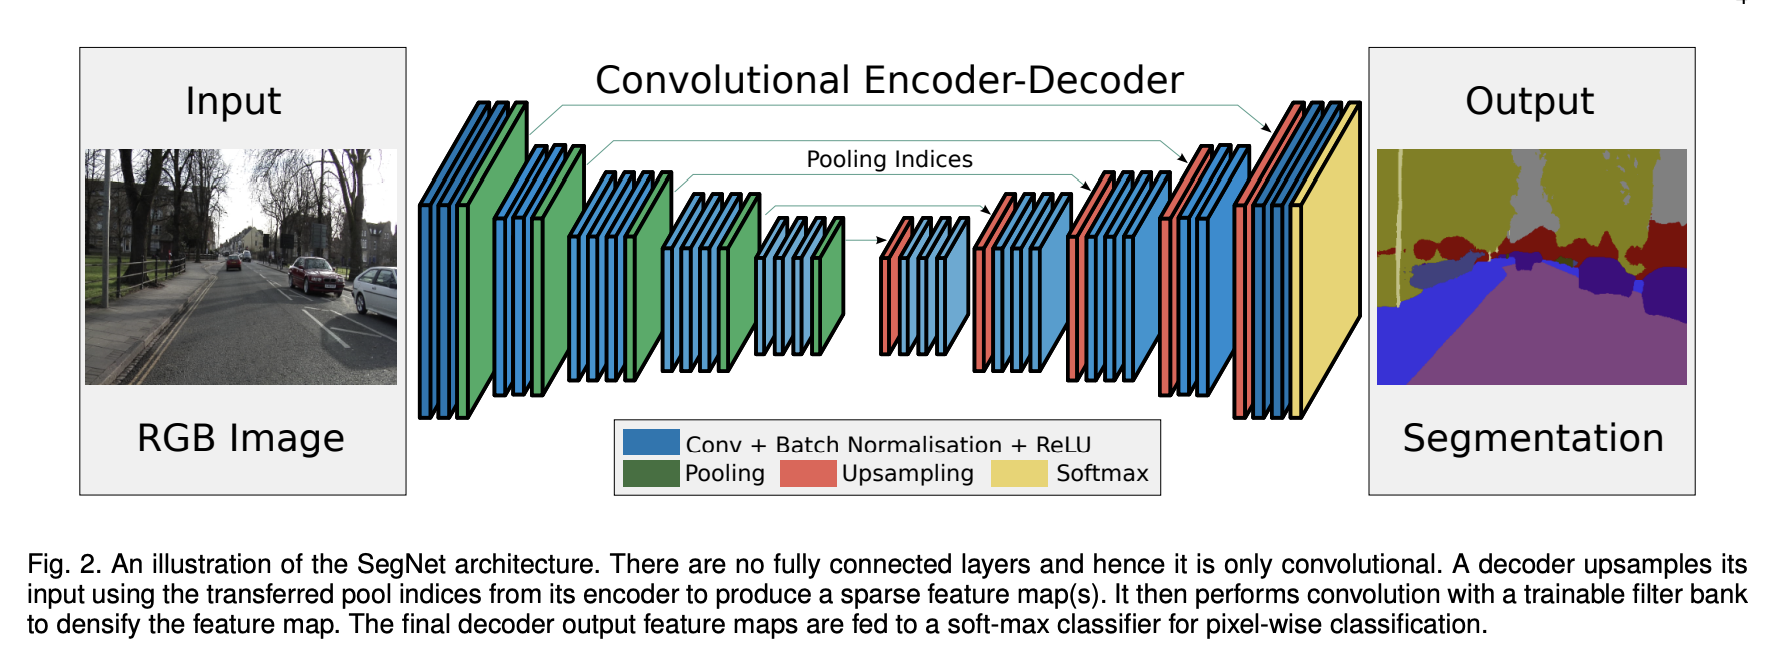

In [91]:
class SegNet(nn.Module):
    def __init__(self, n_classes=3):
        super().__init__()

        # C x  H  x  W
        # 3 x 320 x 512 
        self.enc_conv1 = ConvBlock(in_channels=3, out_channels=64)
        # 64 x 320 x 512
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # 64 x 160 x 256

        self.enc_conv2 = ConvBlock(in_channels=64, out_channels=128)
        # 128 x 160 x 256
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # 128 x 80 x 128

        self.enc_conv3 = ConvBlock(in_channels=128, out_channels=256, layers=3)
        # 256 x 80 x 128
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # 256 x 40 x 64

        self.enc_conv4 = ConvBlock(in_channels=256, out_channels=512, layers=3)
        # 512 x 40 x 64
        self.mp4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # 512 x 20 x 32

        self.enc_conv5 = ConvBlock(in_channels=512, out_channels=1024, layers=3)
        # 1024 x 20 x 32
        self.mp5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # 1024 x 10 x 16

        #### ^^ENCODER^^ | DECODER

        self.upconv5 = nn.MaxUnpool2d( kernel_size=2, stride=2)
        # 1024 x 20 x 32
        self.dec_conv5 = ConvBlock(in_channels=1024, out_channels=512, layers=3)
        # 512 x 20 x 32

        self.upconv4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # 512 x 40 x 64
        self.dec_conv4 = ConvBlock(in_channels=512, out_channels=256, layers=3)
        # 256 x 40 x 64

        self.upconv3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # 256 x 80 x 128
        self.dec_conv3 = ConvBlock(in_channels=256, out_channels=128, layers=3)
        # 128 x 80 x 128

        self.upconv2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # 128 x 160 x 256
        self.dec_conv2 = ConvBlock(in_channels=128, out_channels=64)
        # 64 x 160 x 256

        self.upconv1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # 64 x 320 x 512
        self.dec_conv1 = ConvBlock(in_channels=64, out_channels=n_classes)
        # 3 x 320 x 512

    
    def forward(self, x):
        # Encode
        x_ec1 = self.enc_conv1(x)
        shape1 = x_ec1.shape
        x, idx1 = self.mp1(x_ec1)

        x_ec2 = self.enc_conv2(x)
        shape2 = x_ec2.shape
        x, idx2 = self.mp2(x_ec2)

        x_ec3 = self.enc_conv3(x)
        shape3 = x_ec3.shape
        x, idx3 = self.mp3(x_ec3)

        x_ec4 = self.enc_conv4(x)
        shape4 = x_ec4.shape
        x, idx4 = self.mp4(x_ec4)

        x_ec5 = self.enc_conv5(x)
        shape5 = x_ec5.shape
        x, idx5 = self.mp5(x_ec5)

        # Decode
        x = self.upconv5(x, indices=idx5, output_size=shape5)
        x = self.dec_conv5(x)

        x = self.upconv4(x, indices=idx4, output_size=shape4)
        x = self.dec_conv4(x)

        x = self.upconv3(x, indices=idx3, output_size=shape3)
        x = self.dec_conv3(x)

        x = self.upconv2(x, indices=idx2, output_size=shape2)
        x = self.dec_conv2(x)

        x = self.upconv1(x, indices=idx1, output_size=shape1)
        x = self.dec_conv1(x)

        x = nn.Softmax(dim=1)(x)
        return x

### Components

In [92]:
segnet_model = SegNet()
segnet_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(segnet_model.parameters(), lr=1e-3)
compute_iou = JaccardIndex(num_classes=3, task="multiclass").to(device)

### Verification run - SegNet

In [93]:
images = images.to(device)
outputs = segnet_model(images)
outputs.shape

torch.Size([4, 3, 320, 512])

### Main Training - SegNet

In [94]:
segnet_model_save_name = "model_segnet_state_dict.pth"
segnet_scores = {}
force_retrain = False
if os.path.exists(segnet_model_save_name) and force_retrain == False:
    segnet_model.load_state_dict(torch.load(segnet_model_save_name, map_location=device))
    segnet_scores = torch.load("segnet_scores.pth", map_location=device)
    print("[SegNet] Loaded saved model and metrics")

else:
    segnet_scores = train(
        loader_train=loader_train,
        loader_valid=loader_valid,
        model=segnet_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        n_epochs=10
        )
    torch.save(segnet_model.state_dict(), "model_segnet_state_dict.pth")
    torch.save(segnet_scores, "segnet_scores.pth")

[SegNet] Loaded saved model and metrics


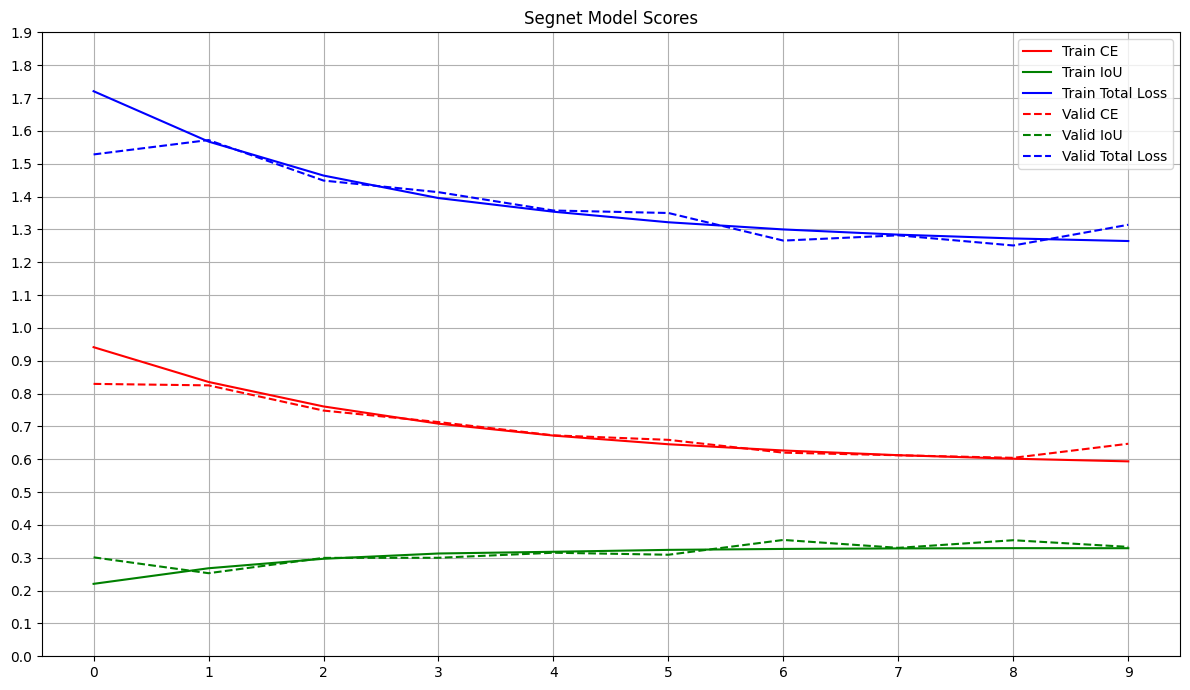

In [95]:
import matplotlib.pyplot as plt

segnet_train, segnet_valid = segnet_scores["train"], segnet_scores["valid"]
plt.figure(figsize=(12, 7))
plt.grid("on")
plt.plot(segnet_train["ce_loss"], color="red", label="Train CE")
plt.plot(segnet_train["iou"], color="green", label="Train IoU")
plt.plot(segnet_train["total"], color="blue", label="Train Total Loss")

plt.plot(segnet_valid["ce_loss"], color="red", linestyle="dashed", label="Valid CE")
plt.plot(segnet_valid["iou"], color="green", linestyle="dashed", label="Valid IoU")
plt.plot(segnet_valid["total"], color="blue", linestyle="dashed", label="Valid Total Loss")

plt.xticks(range(0, 10), range(0, 10))
plt.yticks(np.arange(0, 2.0, 0.1), np.around(np.arange(0, 2.0, 0.1), 2))
plt.title("Segnet Model Scores")
plt.legend()
plt.tight_layout()

In [132]:
# iterable_train_loader = iter(loader_train)
# valid_images, valid_masks = next(iterable_train_loader)
valid_preds_segnet = segnet_model(valid_images)

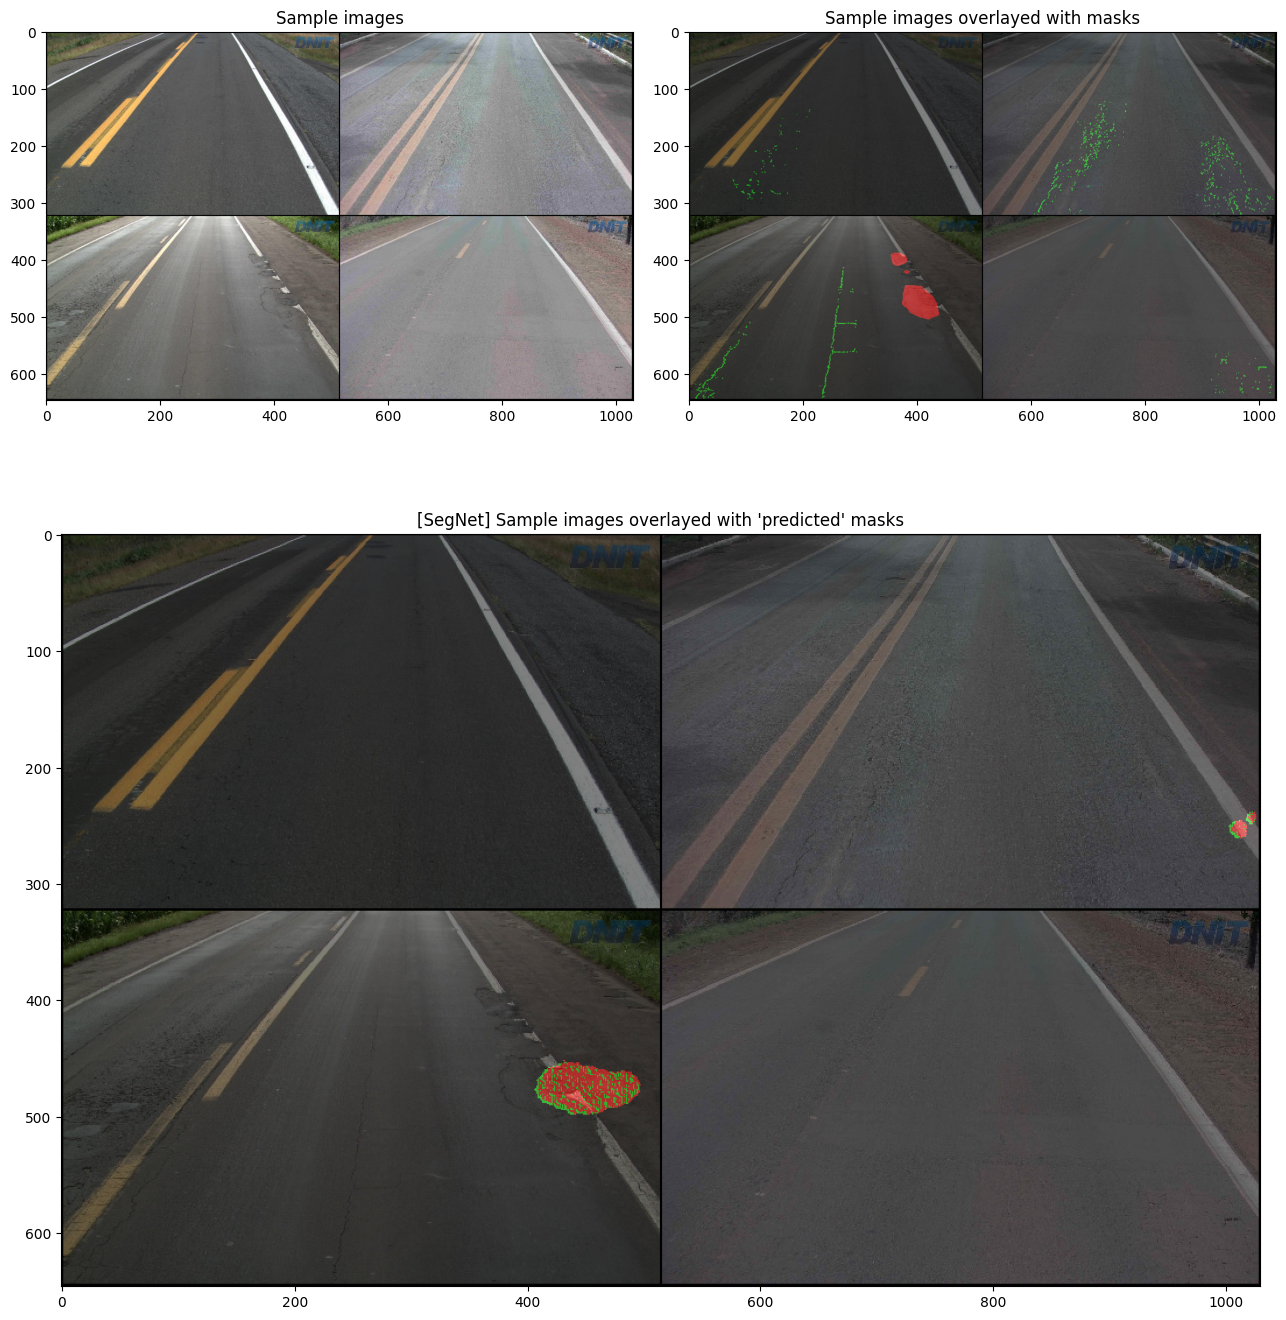

In [133]:
plt.figure(figsize=(13, 15))
plt.subplot(2, 2, 1)
plt.imshow(torchvision.utils.make_grid(valid_images, nrow=2).permute(1, 2, 0))
plt.title("Sample images")
plt.subplot(2, 2, 2)
plt.imshow(torchvision.utils.make_grid(valid_images, nrow=2).permute(1, 2, 0))
plt.imshow(torchvision.utils.make_grid(torch.stack([dataset_train.decode_mask(i) for i in list(valid_masks)]), nrow=2).permute(1, 2, 0), alpha=0.5)
plt.title("Sample images overlayed with masks")
plt.subplot(2, 1, 2)
plt.imshow(torchvision.utils.make_grid(valid_images, nrow=2).permute(1, 2, 0))
plt.imshow(torchvision.utils.make_grid(torch.stack([dataset_train.decode_mask(i) for i in list(valid_preds_segnet.argmax(dim=1))]), nrow=2).permute(1, 2, 0), alpha=0.5)
plt.title("[SegNet] Sample images overlayed with 'predicted' masks")
plt.tight_layout()